In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/Users/fatimabasheer/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
###Data Preprocessing###
insulin=pd.read_csv('InsulinData.csv')
insulin['Timestamp']=pd.to_datetime(insulin['Date']+" "+insulin['Time'])
insulin=insulin.sort_values(by='Timestamp')
cgm=pd.read_csv('CGMData.csv')
cgm['Timestamp']=pd.to_datetime(cgm['Date']+' '+cgm['Time'])
cgm=cgm[['Timestamp','Sensor Glucose (mg/dL)']]
cgm=cgm.sort_values(by='Timestamp')
## Meal Data Extraction ##
meal_times=(insulin[insulin['BWZ Carb Input (grams)'].notna()&(insulin['BWZ Carb Input (grams)']!=0)])[['Timestamp','BWZ Carb Input (grams)']]
valid_meals_ins=pd.DataFrame(columns=meal_times.columns)
#select only valid meal timings
for tm in range(0,len(meal_times)-1):
    if meal_times.iloc[tm+1,0]-meal_times.iloc[tm,0] > pd.Timedelta('02:00:00'):
        valid_meals_ins.loc[len(valid_meals_ins)]=meal_times.iloc[tm]
        
columns_30mins=[f'Glucose_offset-{i}'for i in range(30,0,-5)]
columns_2hrs=[f'Glucose_offset+{i}' for i in range(0,120,5)]
columns=columns_30mins+columns_2hrs+[]
## Meal Data Creation ##
meal_data=pd.DataFrame(columns=columns+['Carb Input'])
#time intervals which'll be cols of new df meal_data
offsets1=[-pd.Timedelta(f'00:{i}:00') for i in range(30,0,-5)]
offsets2=[pd.Timedelta(f'00:{i}:00') for i in range(0,121,5)]
offsets=offsets1+offsets2
for tm,carb in valid_meals_ins[['Timestamp','BWZ Carb Input (grams)']].values:
    filtered_data=[]
    for i in range(len(offsets)-1):
        filtered=cgm[(cgm['Timestamp']>=tm+offsets[i]) & (cgm['Timestamp']<tm+offsets[i+1])]
        if not filtered.empty:
            filtered_data.append(filtered['Sensor Glucose (mg/dL)'].mean(axis=0))
        else:
            filtered_data.append(None)
    filtered_data.append(carb)
    meal_data.loc[len(meal_data)]=filtered_data


In [3]:
## Handling missing data ##

def fill_missing(df):
    for col in df.columns:
        next_values = df[col].shift(-1)
        prev_values = df[col].shift(1)
        temp_df = pd.DataFrame({'prev': prev_values, 'next': next_values})
        df[col] = df[col].fillna(temp_df.mean(axis=1))
    return df

threshold=.3

mealna_counts = meal_data.iloc[:,:-1].isna().sum(axis=1)
meal_data=meal_data[mealna_counts/30<=threshold]
meal_df=(fill_missing(meal_data)).dropna()
# meal_df=meal_data.dropna()
meal_df=meal_df.reset_index(drop=True)
class_size=len(meal_df)
meal_carbs=meal_df

In [4]:
##Feature Extraction##
meal_df=meal_df.drop(columns='Carb Input')
features=['mealCGM','CGM spike duration (mins)','Normalized CGM','F1 (freq1 of CGM wave Fourier Transform)','P1 (power response for F1)'
          ,'F2 (freq2 of CGM wave Fourier Transform)','P2 (power response for F2)','d/dt (CGM wave)','d2/dt2 (CGM wave)']
meal=pd.DataFrame(columns=features)
#mealCGM
meal['mealCGM']=meal_df[['Glucose_offset-10','Glucose_offset-5','Glucose_offset+0','Glucose_offset+5','Glucose_offset+10']].mean(axis=1)

#CGM spike duration (mins)#
spike_col=meal_df.iloc[:,6:].idxmax(axis=1)
spike_col_nums=spike_col.apply(lambda x: pd.to_numeric(x.split('+')[-1]))
meal['CGM spike duration (mins)']=spike_col_nums
#Normalized CGM#
meal['Normalized CGM']=meal.apply(
    lambda row:(
            (meal_df[f'Glucose_offset+{row["CGM spike duration (mins)"]}']-row['mealCGM'])/row['mealCGM']
    ).iloc[row.name]
,axis=1)

#Freqs and power responses for the cgm wave#

def compute_freq_power(sin_wave):
    fft_wave=np.fft.fft(sin_wave)
    fft_magnitude=np.abs(fft_wave)
    power_spectrum=fft_magnitude**2
    fft_freq=np.fft.fftfreq(len(sin_wave),d=5)
    positive_indices=fft_freq>0

    fft_magnitude=fft_magnitude[positive_indices]
    power_spectrum=power_spectrum[positive_indices]
    fft_freq=fft_freq[positive_indices]

    two_indices=np.argsort(power_spectrum)[-2:]
    fft_two_freq=fft_freq[two_indices]
    power_two_freq=power_spectrum[two_indices]
    freq1=fft_two_freq[1]
    freq2=fft_two_freq[0]
    power_response_1=power_two_freq[1]
    power_response_2=power_two_freq[0]
    return pd.Series({'Freq1': freq1,'Freq2':freq2, 'Power Response1': power_response_1,'Power Response2':power_response_2})

points=meal_df.apply(lambda row: row.tolist(),axis=1)
sin_wave_meal=points.apply(lambda row: np.sin(row))

#resample sine wave
def resample_wave(wave, num_points):
    original_len = len(wave)
    new_x = np.linspace(0, original_len - 1, num_points)
    original_x = np.arange(original_len)
    return np.interp(new_x, original_x, wave)

resampled_sin_wave_meal = sin_wave_meal.apply(lambda row: resample_wave(row, 24))

#normalize sine wave
def normalize_wave(wave):
    return (wave - np.min(wave)) / (np.max(wave) - np.min(wave))
normalized_sin_wave_meal = resampled_sin_wave_meal.apply(lambda row: normalize_wave(row))

freq_power_meal=normalized_sin_wave_meal.apply(lambda row: compute_freq_power(row))
meal['F1 (freq1 of CGM wave Fourier Transform)']=freq_power_meal['Freq1']
meal['P1 (power response for F1)']=freq_power_meal['Power Response1']
meal['F2 (freq2 of CGM wave Fourier Transform)']=freq_power_meal['Freq2']
meal['P2 (power response for F2)']=freq_power_meal['Power Response2']

#Derivatives of the cgm wave#
def compute_derivatives(row):
    points = row.values
    first_derivative = np.gradient(points)
    second_derivative = np.gradient(first_derivative)
    return pd.Series({'First Derivative': first_derivative, 'Second Derivative': second_derivative})
derivatives_meal=meal_df.apply(lambda row: compute_derivatives(row),axis=1)
meal['d/dt (CGM wave)']=derivatives_meal['First Derivative'].apply(lambda x: np.mean(x[6:8]))
meal['d2/dt2 (CGM wave)']=derivatives_meal['Second Derivative'].apply(lambda x: np.mean(x[6:8]))
# meal['CGM Duration*Normalized CGM']=meal['CGM spike duration (mins)']*meal['Normalized CGM']
# meal['CGM Duration*MealCGM']=meal['mealCGM']*meal['CGM spike duration (mins)']
# meal['NormalizedCGM*MealCGM']=meal['mealCGM']*meal['Normalized CGM']

In [5]:
## Ground Truth ##
min_carb=meal_carbs['Carb Input'].min()
max_carb=meal_carbs['Carb Input'].max()
bin_len=math.ceil((max_carb-min_carb)/20)
meal.dropna(inplace=True)
print('No. of bins in ground truth : '+str(bin_len))

 
meal['Bin']=(np.floor((meal_carbs['Carb Input']-min_carb)/20)).astype(int)

No. of bins in ground truth : 6


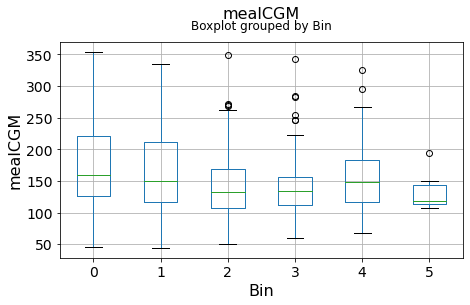

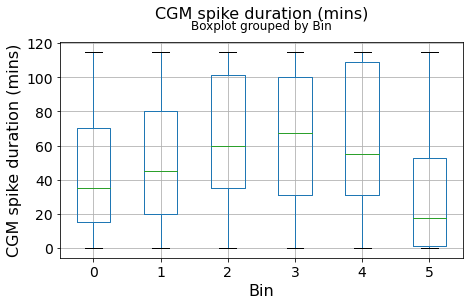

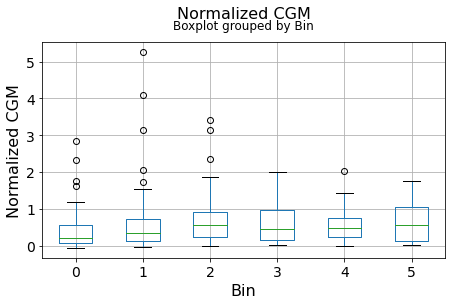

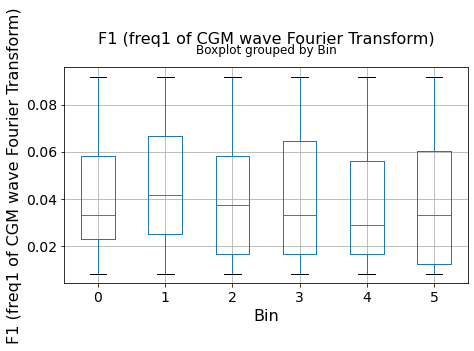

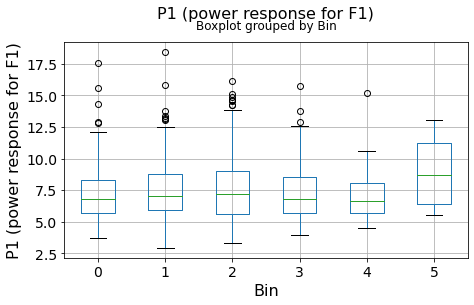

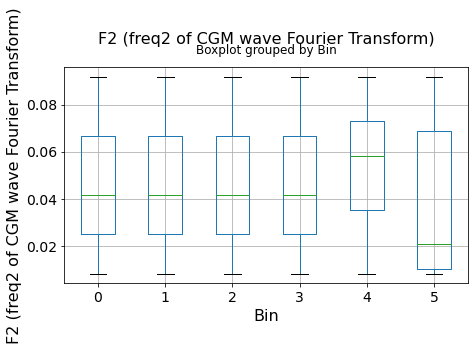

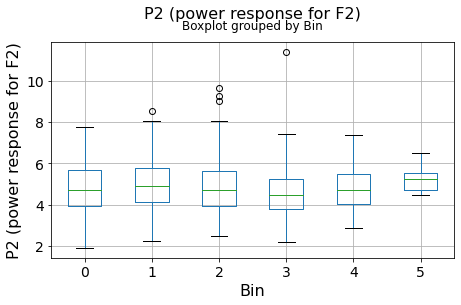

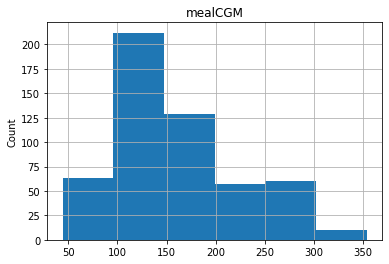

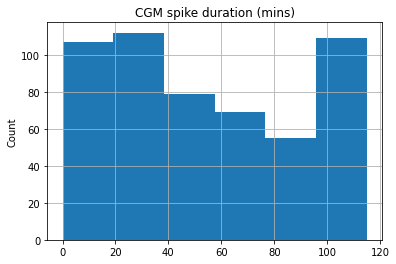

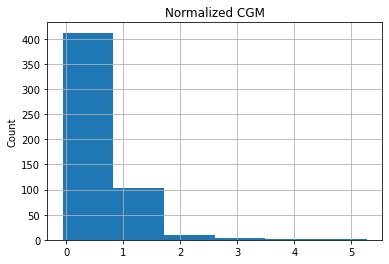

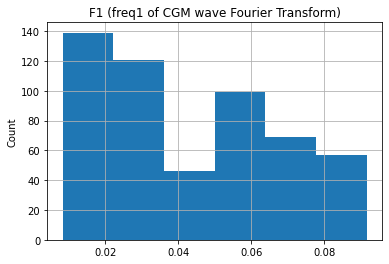

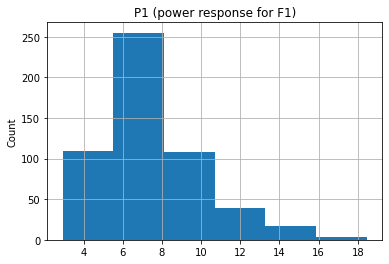

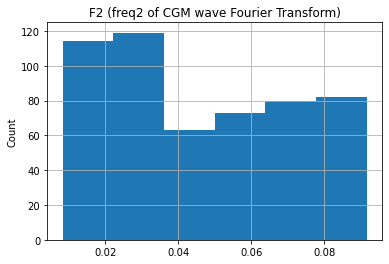

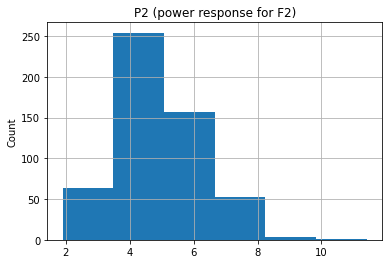

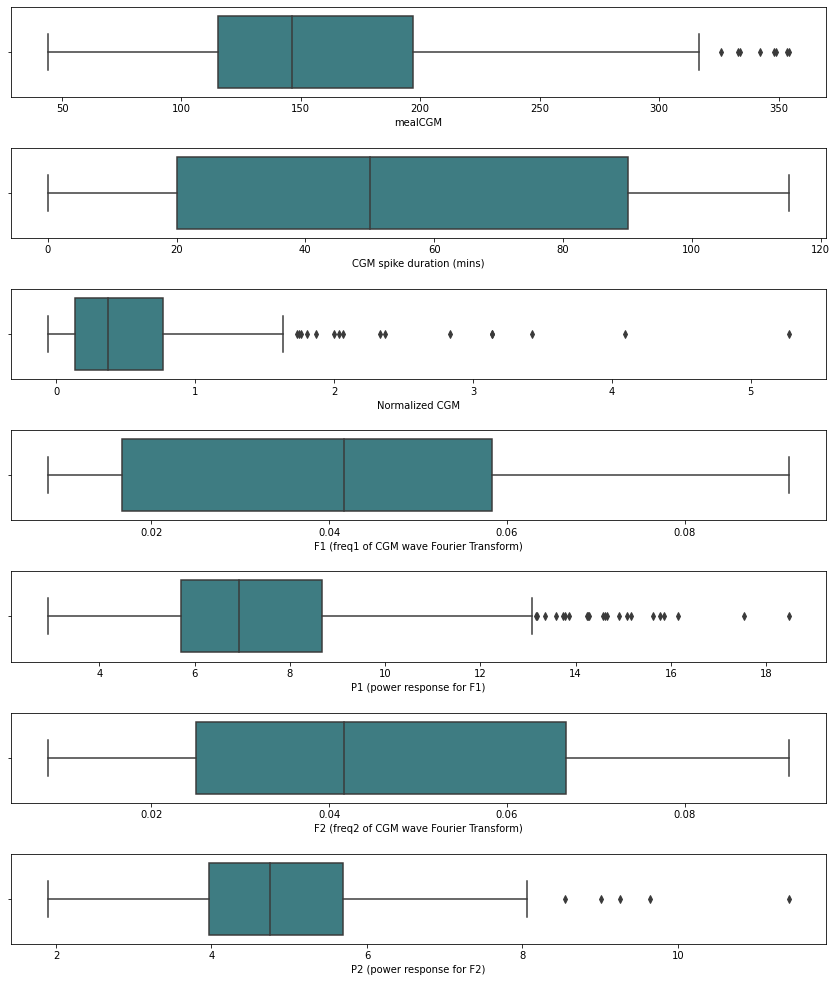

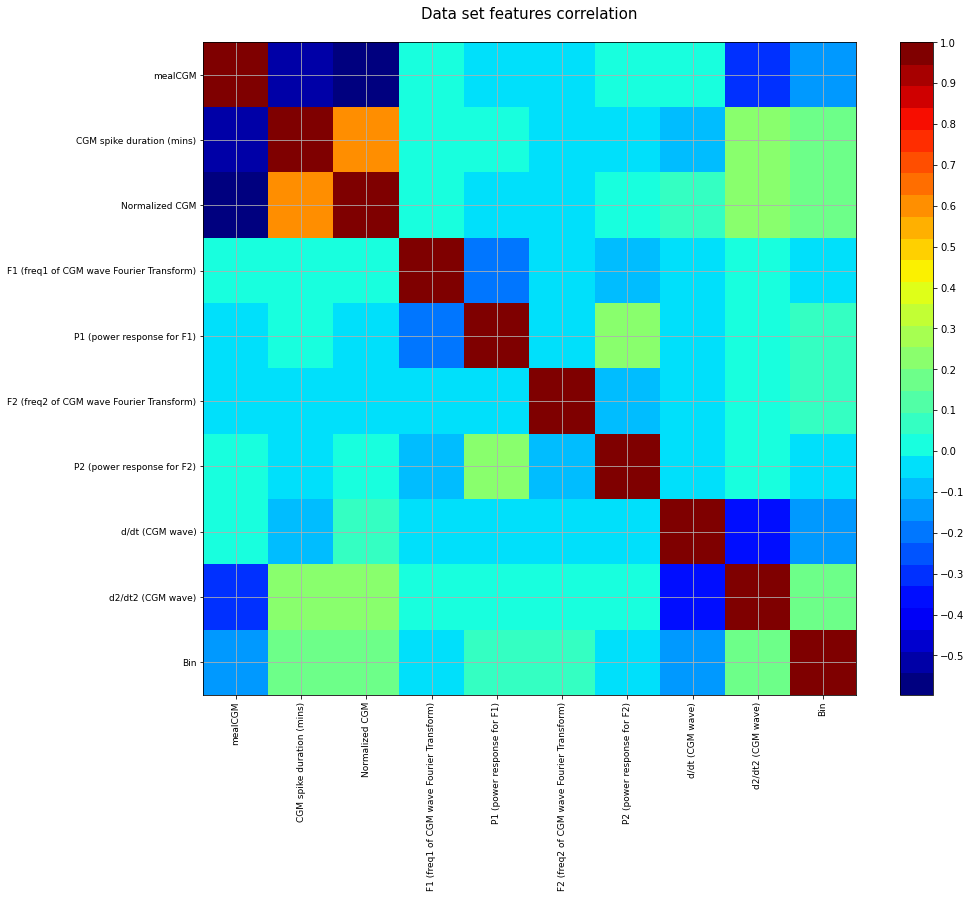

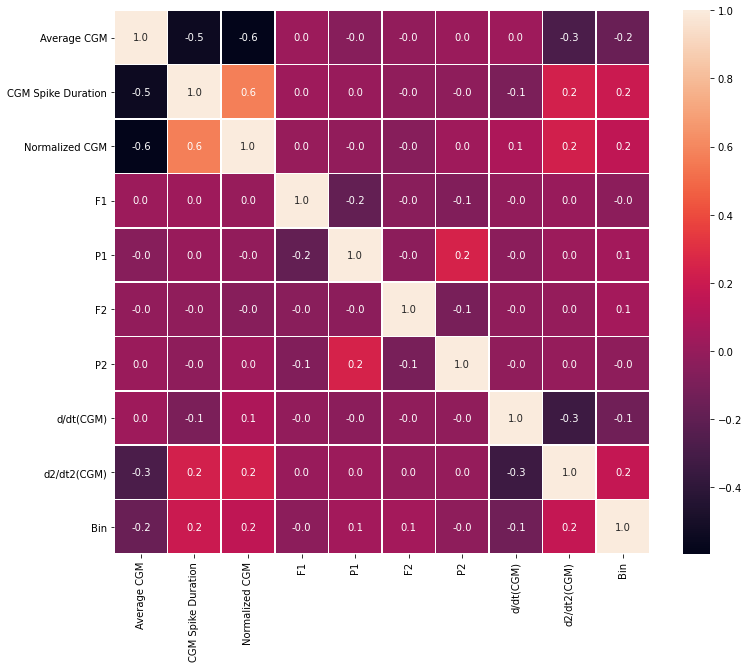

In [10]:
##Distribute to bins each feature##
df = meal.copy()

#Box plot Representation#
for c in df.columns[:-3]:  
    df.boxplot(column=c, by='Bin', figsize=(7, 4), fontsize=14)
    plt.title(f"{c}\n", fontsize=16)  
    plt.xlabel("Bin", fontsize=16) 
    plt.ylabel(c, fontsize=16)  
    plt.show() 
    
#Histogram Represention#
for feature in df.columns[:-3]:
    df_dt = df.copy()
    df_dt[feature].hist(bins=bin_len)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

##Outlier Detection##
outlier = meal.copy() 
fig, axes=plt.subplots(len(outlier.columns[:-3]),1,figsize=(12,14),sharex=False,sharey=False)
for i,col in enumerate(outlier.columns[:-3]):
    sns.boxplot(x=col,data=outlier,palette='crest',ax=axes[i])
plt.tight_layout(pad=2.0)
##Correlation between features##
corr_data=meal
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm
    import numpy as np

    fig = plt.figure(figsize=(16, 12))
    axis1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    corr = df.corr()
    cax = axis1.imshow(corr, interpolation="nearest", cmap=cmap)
    axis1.grid(True)
    plt.title('Data set features correlation\n', fontsize=15)
    labels = df.columns
    axis1.set_xticks(np.arange(len(labels)))
    axis1.set_yticks(np.arange(len(labels)))
    axis1.set_xticklabels(labels, fontsize=9, rotation=90)
    axis1.set_yticklabels(labels, fontsize=9)
    fig.colorbar(cax, ticks=[0.1 * i for i in range(-10, 11)])
    plt.show()

correlation_matrix(corr_data)
labels = ['Average CGM', 'CGM Spike Duration', 'Normalized CGM', 'F1', 'P1', 'F2', 'P2', 'd/dt(CGM)', 'd2/dt2(CGM)', 'Bin']

f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_data.corr(), annot=True, linewidths =.5, fmt ='.1f',ax=ax,xticklabels=labels,yticklabels=labels)
plt.show()


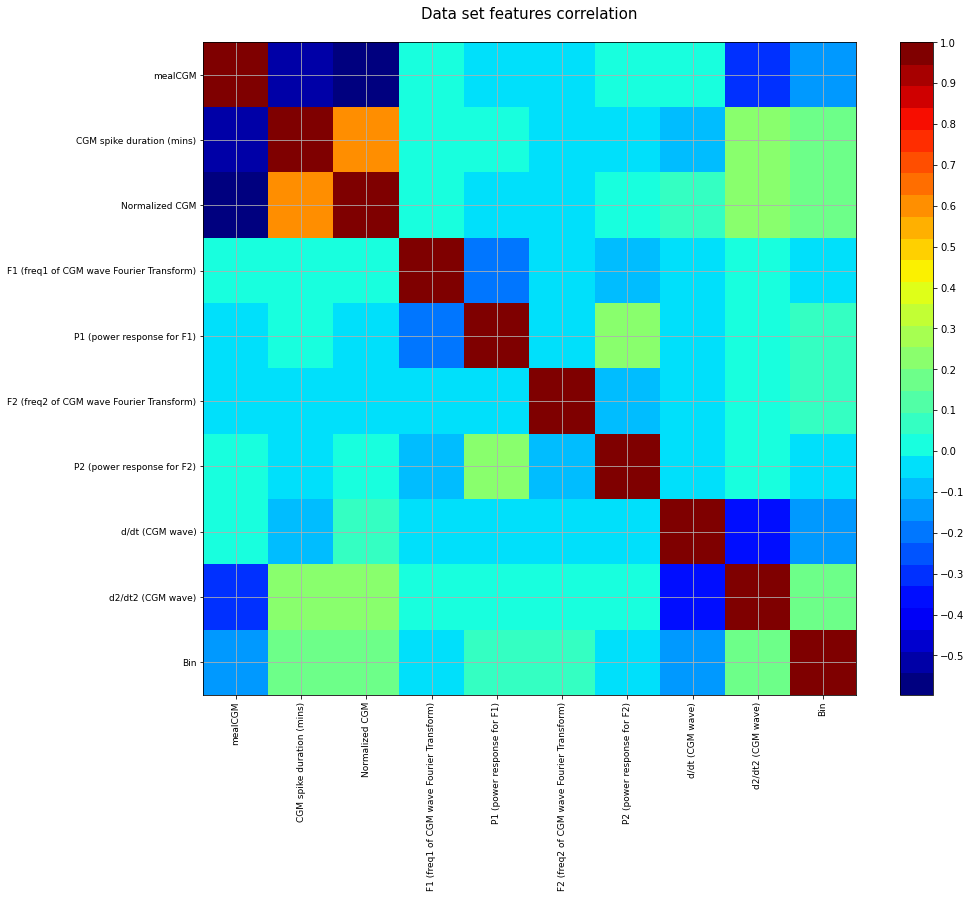

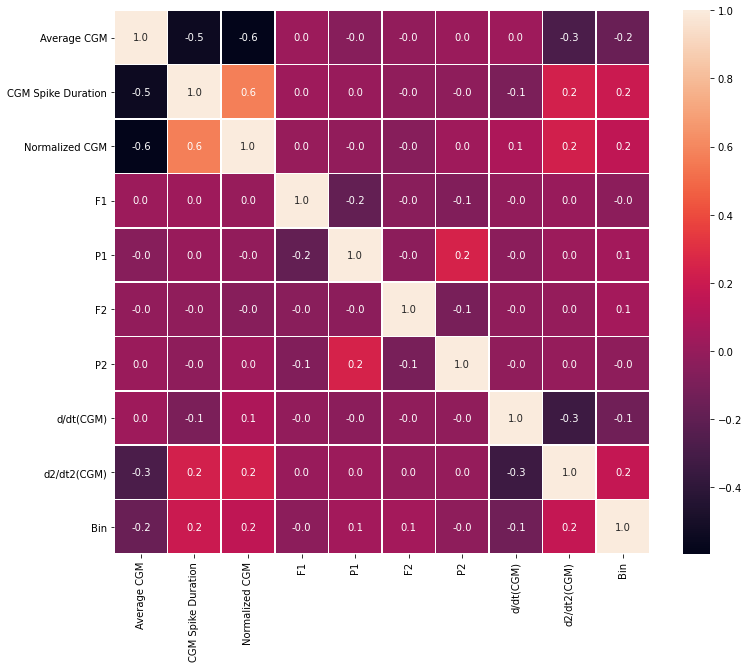

In [11]:
correlation_matrix(corr_data)
labels = ['Average CGM', 'CGM Spike Duration', 'Normalized CGM', 'F1', 'P1', 'F2', 'P2', 'd/dt(CGM)', 'd2/dt2(CGM)', 'Bin']

f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_data.corr(), annot=True, linewidths =.5, fmt ='.1f',ax=ax,xticklabels=labels,yticklabels=labels)
plt.show()

In [12]:
def SSE_cluster(clusters):
    SSEs=[]
    for cluster in clusters:
        centroid=cluster.mean(axis=0)
        SSE=0
        for index, row in cluster.iterrows():
            SSE += SSE_point(row, centroid)
        SSEs.append(SSE)
    return SSEs
    
def SSE_point(point,center):
    return np.sum((point - center) ** 2)

def SSE_total(X, labels, centers):
    total_sse = 0
    for i in range(len(X)):
        total_sse+=SSE_point(X[i],centers[labels[i]])
    return total_sse

def ground_truth_matrix(meal,labels):
    mat=[[0 for _ in range(bin_len)] for _ in range(bin_len)]
    def fill_mat(row):
        i=int(labels[row.name])
        j=int(row['Bin'])
#         print(str(i)+" "+str(j))
        mat[i][j]+=1
    meal.apply(fill_mat,axis=1)
    return mat
        
def entropy(row,sum_row):
    probs = [col / sum_row for col in row if col > 0]
    return -sum(p * math.log(p, 2) for p in probs)

def entropy_total(truth_matrix):
    total_entropy=0
    sum_total=0
    for row in truth_matrix:
        sum_row=sum(row)
        if sum_row>0:
            total_entropy+=entropy(row,sum_row)*sum_row
            sum_total+=sum_row
    return total_entropy/sum_total
        
def purity_total(truth_matrix):
    total_purity=0
    sum_total=0
    for row in truth_matrix:
        total_purity+=max(row)
        sum_total+=sum(row)
    return total_purity/sum_total if sum_total>0 else 0

In [13]:
# ['mealCGM','CGM spike duration (mins)','Normalized CGM','F1 (freq1 of CGM wave Fourier Transform)','P1 (power response for F1)'
#           ,'F2 (freq2 of CGM wave Fourier Transform)','P2 (power response for F2)','d/dt (CGM wave)','d2/dt2 (CGM wave)']
X=meal.drop(columns=['F1 (freq1 of CGM wave Fourier Transform)','P2 (power response for F2)'])
X_train=X.iloc[:,:-1]
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train)

minmax = MinMaxScaler()
X_norm = minmax.fit_transform(X_scaled)

##Removing Outliers##
# sscore: 0.450563767727707,Optimal parameters: eps = 0.21751751751751752, min_samples = 12, data_size=171
# Best silhouette score: 0.655050868472534,Optimal parameters: eps = 0.2, min_samples = 12, data_size=24
# Best silhouette score: 0.6599486867072041,Optimal parameters: eps = 0.20454545454545453, min_samples = 7, data_size=30

dbscan = DBSCAN(eps=0.20454545454545453, min_samples=7)
dbscan.fit(X_norm)
dbscan_labels = dbscan.labels_
X_norm=X_norm[dbscan_labels != -1]
X_meal=(X[dbscan_labels!=-1]).reset_index(drop=True)

def perturb_centroids(centroids, noise_level):
    # Adding Gaussian noise perturbation to the centroids
    noise = np.random.normal(0, noise_level, centroids.shape)
    perturbed_centroids = centroids + noise
    return perturbed_centroids

pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_norm)

kmeans=KMeans(n_clusters=bin_len,init='k-means++', n_init=100, random_state=np.random.seed(42))
kmeans.fit(X_reduced)
centers=kmeans.cluster_centers_
labels=kmeans.labels_

perturbed_centers = perturb_centroids(centers, noise_level=0.05)
kmeans_with_perturbation = KMeans(n_clusters=bin_len, init=perturbed_centers,random_state=np.random.seed(42))
kmeans_with_perturbation.fit(X_reduced)
final_labels = kmeans_with_perturbation.labels_
final_centers = kmeans_with_perturbation.cluster_centers_
truth_matrix=ground_truth_matrix(X_meal,final_labels)
SSE_kmeans=SSE_total(X_reduced,final_labels, final_centers)
entropy_kmeans=entropy_total(truth_matrix)
purity_kmeans=purity_total(truth_matrix)

# truth_matrix=ground_truth_matrix(X_meal,labels)
# SSE_kmeans=SSE_total(X_reduced,labels, centers)
# entropy_kmeans=entropy_total(truth_matrix)
# purity_kmeans=purity_total(truth_matrix)

print("SSE for kmeans: "+str(SSE_kmeans))
print("Entropy for kmeans: "+str(entropy_kmeans))
print("Purity for kmeans: "+str(purity_kmeans))

# #Plot variance ration for the principal component features##
# plt.figure(figsize=(10,6))
# plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
#             y=pca.explained_variance_ratio_,
#            s=200, alpha=0.75,c='red',edgecolor='k')
# plt.grid(True)
# plt.title("Variance ratio of the principal component features",fontsize=25)
# plt.xlabel("Principal components",fontsize=15)
# plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))],fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylabel("Explained variance ratio",fontsize=15)
# plt.show()


SSE for kmeans: 23.4191834000406
Entropy for kmeans: 2.0974482407906034
Purity for kmeans: 0.35638297872340424


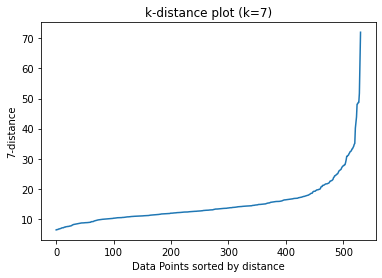

In [21]:

def plot_k_distance(X, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.ylabel(f'{k}-distance')
    plt.xlabel('Data Points sorted by distance')
    plt.title(f'k-distance plot (k={k})')
    plt.show()
    
X = meal.drop(columns=['F1 (freq1 of CGM wave Fourier Transform)','P2 (power response for F2)','Bin'])
plot_k_distance(X, k=7)

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

minmax = MinMaxScaler()
X_norm = minmax.fit_transform(X_scaled)

eps_values = np.linspace(0.20,0.30,1000)
min_samples_values = [7]#,0.24 - 12]

best_score = -1
best_params = {}
best_datasize = 0
for eps in eps_values:
    for min_samples in min_samples_values:

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_norm)
        
        X_norm=X_norm[labels != -1]
        labels=labels[labels!=-1]
        if len(set(labels)) > 1:
            score = silhouette_score(X_norm, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_datasize=len(labels)
if best_score>-1:
    print(f"Best silhouette score: {best_score},Optimal parameters: eps = {best_params['eps']}, min_samples = {best_params['min_samples']}, data_size={best_datasize}")

In [614]:
def bisecting_kmeans(X, target_clusters):
    clusters = [X]
    max_sse=0
    while len(clusters) < target_clusters:
        max_sse = SSE_cluster(clusters)
        max_index = max_sse.index(max(max_sse))
        bisect_cluster = clusters[max_index]
#         pca=PCA(n_components=5)
#         X_reduced=pca.fit_transform(bisect_cluster)
        kmeans = KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=42)
        labels = kmeans.fit_predict(bisect_cluster)
        new_clusters = [bisect_cluster[labels == 0], bisect_cluster[labels == 1]]
        clusters.pop(max_index)
        clusters.extend(new_clusters)
    return clusters,sum(max_sse)


X=meal.drop(columns=['F1 (freq1 of CGM wave Fourier Transform)','P2 (power response for F2)'])
X_train=X.iloc[:,:-1]
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X_train)

minmax = MinMaxScaler()
X_norm = minmax.fit_transform(X_scaled)

# X_norm=X_scaled
# pca=PCA(n_components=1)
# X_reduced=pca.fit_transform(X_norm)

dbscan = DBSCAN(eps=0.20454545454545453, min_samples=7)
dbscan.fit(X_norm)
dbscan_labels = dbscan.labels_

valid_X=pd.concat([pd.DataFrame(X_norm[dbscan_labels != -1]), X[['Bin']][dbscan_labels != -1].reset_index(drop=True)], axis=1)
filtered_data=valid_X.drop(columns='Bin')
filtered_labels=[x for x in dbscan_labels if x!=-1]

target_clusters=bin_len
bisected_clusters,sse = bisecting_kmeans(filtered_data,target_clusters)

def assign_labels(filtered_data):
    labels=[0]*len(filtered_data)
    for i,cluster in enumerate(bisected_clusters):
        for index, row in cluster.iterrows():
            labels[row.name] = i
    return labels
labels=assign_labels(filtered_data)

def compute_centers(bisected_clusters):
    centers=[]
    for cluster in bisected_clusters:
        center=cluster.mean(axis=0)
        centers.append(center)
    return centers
centers=compute_centers(bisected_clusters)

# # plt.scatter(X.iloc[:,0],X.iloc[:,1] , c=dbscan_labels, s=50, cmap='viridis')
# # plt.title('Bisecting KMeans Clustering of DBSCAN Result')
# # plt.xlabel('PCA Component 1')
# # plt.ylabel('PCA Component 2')
# # plt.show()
# # filtered_meal = meal[meal.index.isin(filtered_data.index)]

#provided no noise data points are there    
truth_matrix=ground_truth_matrix(valid_X,labels)
SSE_dbscan=sse
entropy_dbscan=entropy_total(truth_matrix)
purity_dbscan=purity_total(truth_matrix)

print("SSE for dbscan: "+str(SSE_dbscan))
print("Entropy for dbscan: "+str(entropy_dbscan))
print("Purity for dbscan: "+str(purity_dbscan))

SSE for dbscan: 30.023408424970267
Entropy for dbscan: 2.104089240733535
Purity for dbscan: 0.3670212765957447


In [545]:
result=np.array([[SSE_kmeans,SSE_dbscan,entropy_kmeans,entropy_dbscan,purity_kmeans,purity_dbscan]])
df=pd.DataFrame(result)
df.to_csv('Result.csv',header=False,index=False)

In [105]:
len(dbscan_labels)

531

In [91]:
print(set(dbscan_labels))

{-1}


In [150]:
print(bisected_clusters[2])

       0         1         2         3
0    0.1  0.119528  0.519760  0.629602
4    0.0  0.212346  0.380838  0.736289
11   0.1  0.127002  0.531737  0.760331
14   0.0  0.261216  0.493413  0.751315
41   0.1  0.210025  0.409581  0.752817
..   ...       ...       ...       ...
451  0.0  0.068645  0.395210  0.719760
453  0.0  0.247661  0.433533  0.707739
456  0.1  0.270380  0.335329  0.772352
457  0.1  0.238979  0.443114  0.754320
467  0.0  0.222471  0.356886  0.710744

[86 rows x 4 columns]


In [232]:
print((X_meal))

     F1 (freq1 of CGM wave Fourier Transform)  P2 (power response for F2)  \
0                                    0.016667                    3.300292   
1                                    0.041667                    4.301671   
2                                    0.058333                    6.055427   
3                                    0.066667                    3.510682   
4                                    0.008333                    4.239895   
..                                        ...                         ...   
524                                  0.041667                    4.236143   
527                                  0.025000                    6.680689   
528                                  0.066667                    4.747889   
529                                  0.008333                    4.342384   
530                                  0.008333                    6.143275   

     d/dt (CGM wave)  d2/dt2 (CGM wave) Bin  
0              13.50         

In [358]:
meal_df.head()

,Glucose_offset-30,Glucose_offset-25,Glucose_offset-20,Glucose_offset-15,Glucose_offset-10,Glucose_offset-5,Glucose_offset+0,Glucose_offset+5,Glucose_offset+10,Glucose_offset+15,...,Glucose_offset+60,Glucose_offset+65,Glucose_offset+70,Glucose_offset+75,Glucose_offset+80,Glucose_offset+85,Glucose_offset+90,Glucose_offset+95,Glucose_offset+100,Glucose_offset+105
0,58.0,59.0,63.0,71.0,81.0,102.0,131.0,140.0,147.0,153.0,...,256.0,166.0,168.0,164.0,169.0,178.0,184.0,190.0,195.0,198.0
1,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,256.0,262.0,270.0,277.0,274.0,269.0,267.0,267.0,274.0,284.0
2,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,69.0,66.0,67.0,71.0,75.0,74.0,72.0,70.0,67.0,74.0
3,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,203.0,205.0,210.0,213.0,212.0,216.0,213.0,210.0,210.0,209.0
4,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,213.0,204.0,200.0,196.0,189.0,183.0,179.0,177.0,173.0,165.0


In [278]:
print(len(X_reduced))
print(len(final_labels))
print(len(X_meal))
print(len(dbscan_labels))

46
46
46
531


In [434]:
print(len(dbscan_labels[dbscan_labels!=-1]))

531


In [352]:
print(meal_data.head())

   Glucose_offset-30  Glucose_offset-25  Glucose_offset-20  Glucose_offset-15  \
0                NaN                NaN                NaN                NaN   
1               58.0               59.0               63.0               71.0   
2              304.0              292.0              281.0              268.0   
3               40.0               40.0               40.0               40.0   
4              212.0              210.0              204.0              200.0   

   Glucose_offset-10  Glucose_offset-5  Glucose_offset+0  Glucose_offset+5  \
0                NaN               NaN               NaN               NaN   
1               81.0             102.0             131.0             140.0   
2              259.0             255.0             248.0             241.0   
3               60.0              71.0              83.0              87.0   
4              199.0             201.0             201.0             194.0   

   Glucose_offset+10  Glucose_offset+15  ...

In [477]:
print(len(X_meal))
print(len(labels))

420
420


In [592]:
print(len(filtered_labels))

7
